In [152]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
import sklearn.metrics as metrics
from tqdm import tqdm

In [153]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [154]:
ptv_result = [0] * 9

In [155]:
with open(f'ptv_cbi_q_10.pickle', mode='rb') as fp:
    ptv_result[0] = pickle.load(fp)
with open(f'ptv_cbi_q_20.pickle', mode='rb') as fp:
    ptv_result[1] = pickle.load(fp)
# with open(f'ptv_cbi_q_30.pickle', mode='rb') as fp:
#     ptv_result[2] = pickle.load(fp)
with open(f'ptv_cbi_q_30_high.pickle', mode='rb') as fp:
    ptv_result[2] = pickle.load(fp)
with open(f'ptv_rbi_q_10_1.pickle', mode='rb') as fp:
    ptv_result[3] = pickle.load(fp)
with open(f'ptv_rbi_q_10_2.pickle', mode='rb') as fp:
    ptv_result[4] = pickle.load(fp)
with open(f'ptv_rbi_q_20_1.pickle', mode='rb') as fp:
    ptv_result[5] = pickle.load(fp)
with open(f'ptv_rbi_q_20_2.pickle', mode='rb') as fp:
    ptv_result[6] = pickle.load(fp)
with open(f'ptv_rbi_q_30_1.pickle', mode='rb') as fp:
    ptv_result[7] = pickle.load(fp)
with open(f'ptv_rbi_q_30_2.pickle', mode='rb') as fp:
    ptv_result[8] = pickle.load(fp)

In [156]:
for i in range(9):
    ptv_result[i]['r'] = np.sqrt(ptv_result[i]['x']**2 + ptv_result[i]['y']**2)

In [157]:
px2mm = 1000 / np.sqrt((498 - 488)**2 + (391 - 646)**2)
fps = 25

In [158]:
ptv_result[0]['r'].max()*px2mm

1973.8469844976996

In [159]:
res_sort = [0] * 9

for i in range(9):
    res_sort[i] = ptv_result[i].sort_values(by='r', ascending=True).values

In [160]:
_iter = 50
res = [0]*9
res2 = [0]*9

In [161]:
for c in range(9):
    r_dr_err = np.zeros((5001, 3))
    r_dr_in = np.zeros((1, 2))
    r_dr_err[:, :] = np.nan
    r_dr_in[:, :] = np.nan

    for i in tqdm(range(0, 5001, _iter)):
        res_sort_l = res_sort[c][np.where(res_sort[c][:, 4] >= i/10)]
        res_sort_lr = res_sort_l[np.where(res_sort_l[:, 4] < (i+_iter)/10)]
        columns = ['x', 'y', 'dx', 'dy', 'r', 'theta', 'dr']
        df = pd.DataFrame(data=res_sort_lr, columns=columns, dtype='float')
        q1 = df['dr'].quantile(0.25)
        q2 = df['dr'].quantile(0.75)
        iqr = q2 - q1

        upper = q2 + 1.5 * iqr
        bottom = q1 - 1.5 * iqr
        _in = df[(df['dr'] >= bottom) & (df['dr'] <= upper)].values
        tmp = np.array([_in[:, 4], _in[:, 6]]).T
        r_dr_in = np.vstack([r_dr_in, tmp])

        r_dr_err[i, 0] = i
        r_dr_err[i, 1] = np.mean(tmp, axis=0)[1]
        r_dr_err[i, 2] = np.std(tmp, axis=0)[1]

    r_dr_err = r_dr_err[::_iter]
    res[c] = r_dr_err
    res2[c] = r_dr_in

100%|██████████| 101/101 [00:00<00:00, 129.48it/s]


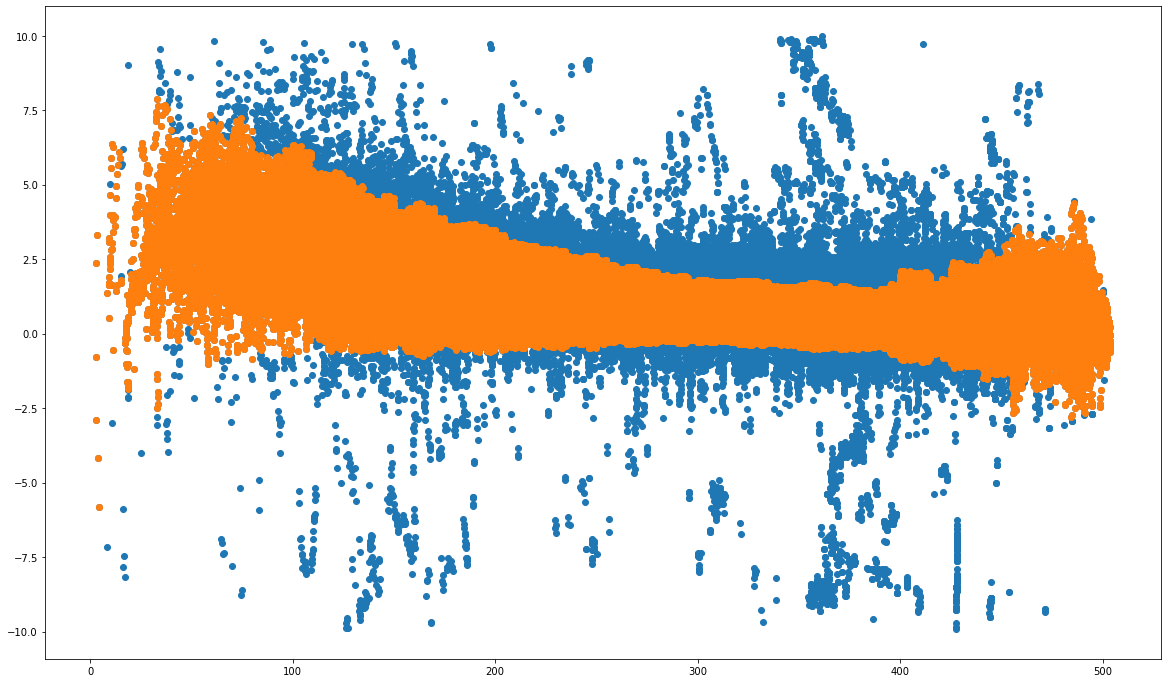

In [162]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(ptv_result[0]['r'], ptv_result[0]['dr'])
ax.scatter(res2[0][:, 0], res2[0][:, 1])
plt.show()

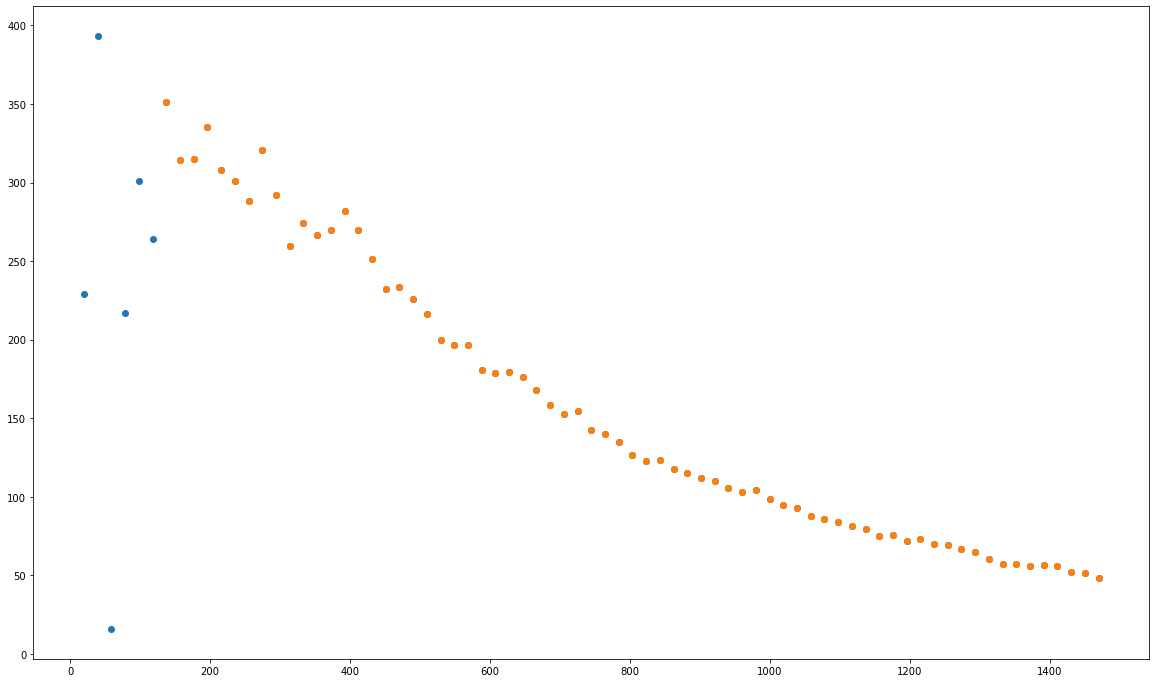

In [163]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[0][1:-25, 0]*px2mm/10, res[0][1:-25, 1]*px2mm*fps)
ax.scatter(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps)
plt.show()

In [164]:
def fit_func(params, x, y):
    return y - (params[0] / x + params[1])

def fit_func2(params, x, y):
    return y - (params[0] / x**2 + params[1])

def fit_exp(params, x, y):
    return y - (params[0] * np.exp(params[1] * x))

def func(params, x):
    return params[0] / x + params[1]

def func_2(params, x):
    return params[0] / x**2 + params[1]

def func_exp(params, x):
    return params[0] * np.exp(params[1] * x)

In [165]:
def fit_pow(params, x, y):
    return y - (params[0] * np.power(x, params[1]) + params[2])

def fit_pow2(params, x, y):
    return y - (params[0] * np.power(x, params[1]))

def func_pow(params, x):
    return params[0] * np.power(x, params[1]) + params[2]

def func_pow2(params, x):
    return params[0] * np.power(x, params[1])

In [166]:
result = optimize.leastsq(fit_func, np.array([9., 0.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))
result2 = optimize.leastsq(fit_func2, np.array([9., 0.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))
result_exp = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))
result_pow = optimize.leastsq(fit_pow, np.array([1., 1., 1.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))

r2 = metrics.r2_score(res[0][7:-25, 1]*px2mm*fps, func(result[0], res[0][7:-25, 0]*px2mm/10))
r2_2 = metrics.r2_score(res[0][7:-25, 1]*px2mm*fps, func_2(result2[0], res[0][7:-25, 0]*px2mm/10))
r2_exp = metrics.r2_score(res[0][7:-25, 1]*px2mm*fps, func_exp(result_exp[0], res[0][7:-25, 0]*px2mm/10))

print(result[0][0], result[0][1], r2)
print(result2[0][0], result2[0][1], r2_2)
print(result_exp[0][0], result_exp[0][1], r2_exp)

56376.21632420491 55.41280483363592 0.801840331222036
7011018.975396585 120.50149254310003 0.5546778618690152
438.54720538205623 -0.0014678951107303289 0.9867802703858709


In [167]:
r = np.linspace(150, 1500, 1351)
a = 1 / r * result[0][0] + result[0][1]
b = 1 / r**2 * result2[0][0] + result2[0][1]
c = result_exp[0][0] * np.exp(result_exp[0][1] * r)

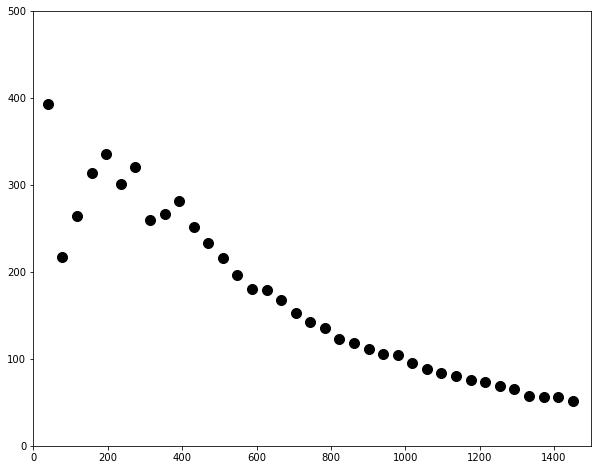

In [168]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlim(0, 1500)
plt.ylim(0, 500)

ax.scatter(res[0][:-25, 0][::2]*px2mm/10, res[0][:-25, 1][::2]*px2mm*fps, c='k', marker='o', s=100)
# ax.plot(r, a, linewidth=4, c='b')
# ax.plot(r, b, linewidth=4, c='g')
# ax.plot(r, c, linewidth=4, c='r')
# ax.plot(r, result_pow[0][0] * np.power(r, result_pow[0][1]) + result_pow[0][2], linewidth=4, c='orange')
plt.show()
fig.savefig('approximate0.png')

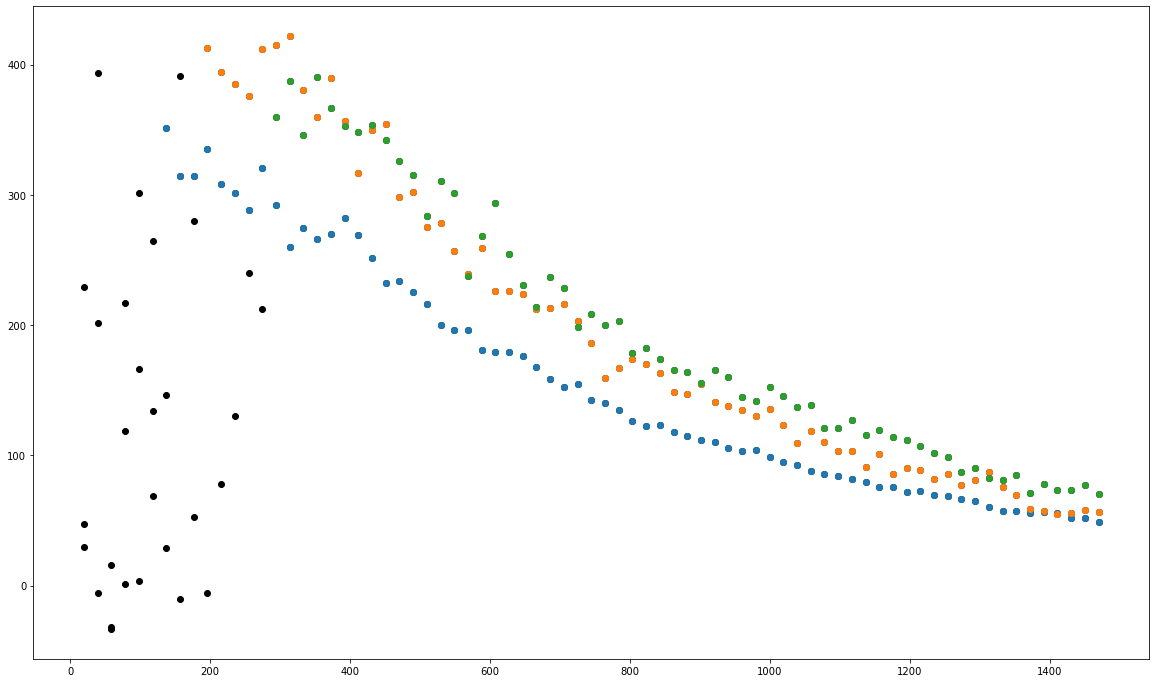

In [169]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[0][1:-25, 0]*px2mm/10, res[0][1:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[1][1:-25, 0]*px2mm/10, res[1][1:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[2][1:-25, 0]*px2mm/10, res[2][1:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps)
ax.scatter(res[1][10:-25, 0]*px2mm/10, res[1][10:-25, 1]*px2mm*fps)
ax.scatter(res[2][15:-25, 0]*px2mm/10, res[2][15:-25, 1]*px2mm*fps)
plt.show()

438.54720538205623 -0.0014678951107303289 0.9867802703858709
619.896349762473 -0.001580380688533468 0.9770331003300629
623.6500769254951 -0.0014709771670598233 0.9804792244922871


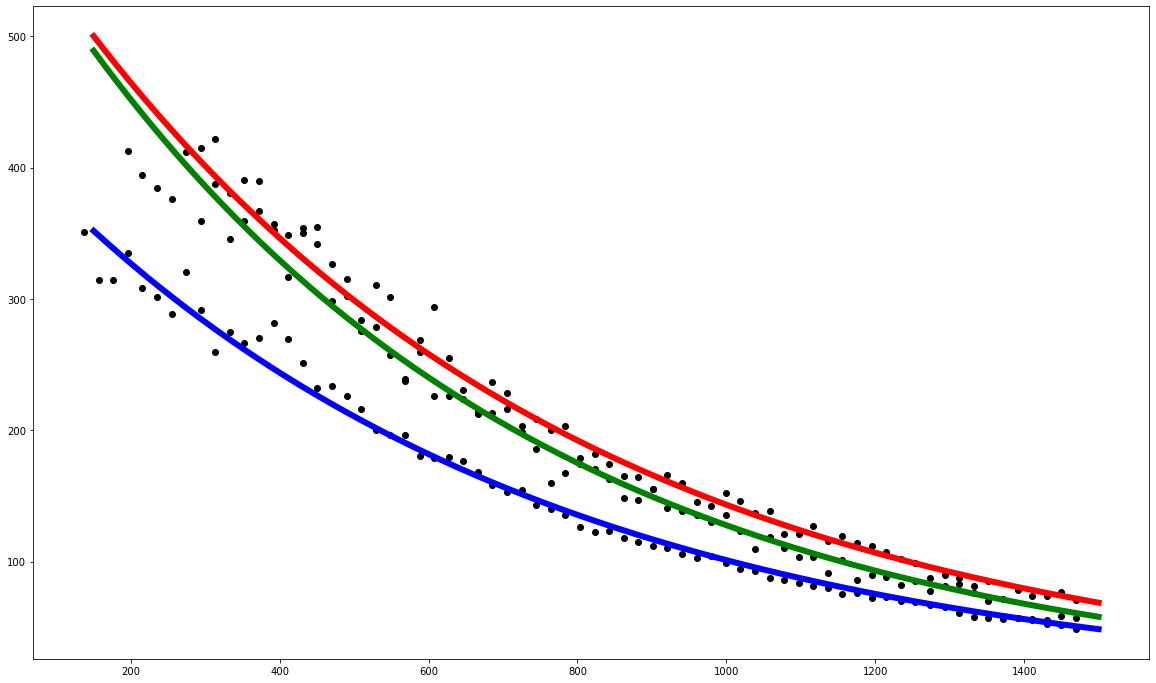

In [170]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[1][10:-25, 0]*px2mm/10, res[1][10:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[2][15:-25, 0]*px2mm/10, res[2][15:-25, 1]*px2mm*fps, c='k')

result_exp = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))
result_exp2 = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[1][10:-25, 0]*px2mm/10, res[1][10:-25, 1]*px2mm*fps))
result_exp3 = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[2][15:-25, 0]*px2mm/10, res[2][15:-25, 1]*px2mm*fps))

r2_exp = metrics.r2_score(res[0][7:-25, 1]*px2mm*fps, func_exp(result_exp[0], res[0][7:-25, 0]*px2mm/10))
r2_exp2 = metrics.r2_score(res[1][10:-25, 1]*px2mm*fps, func_exp(result_exp2[0], res[1][10:-25, 0]*px2mm/10))
r2_exp3 = metrics.r2_score(res[2][15:-25, 1]*px2mm*fps, func_exp(result_exp3[0], res[2][15:-25, 0]*px2mm/10))

print(result_exp[0][0], result_exp[0][1], r2_exp)
print(result_exp2[0][0], result_exp2[0][1], r2_exp2)
print(result_exp3[0][0], result_exp3[0][1], r2_exp3)

ax.plot(r, result_exp[0][0] * np.exp(result_exp[0][1] * r), linewidth=6, c='b')
ax.plot(r, result_exp2[0][0] * np.exp(result_exp2[0][1] * r), linewidth=6, c='g')
ax.plot(r, result_exp3[0][0] * np.exp(result_exp3[0][1] * r), linewidth=6, c='r')

plt.show()

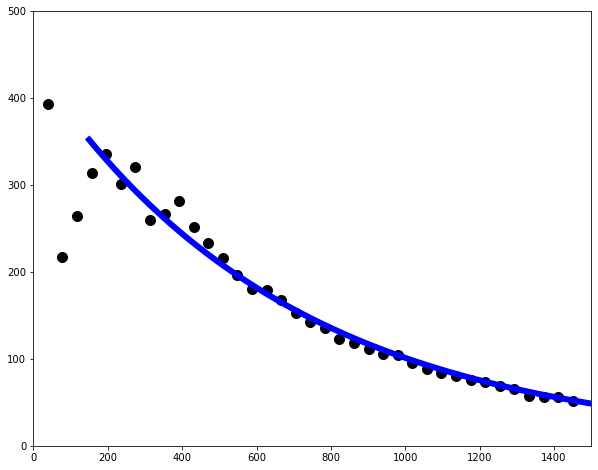

In [171]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlim(0, 1500)
plt.ylim(0, 500)

ax.scatter(res[0][:-25, 0][::2]*px2mm/10, res[0][:-25, 1][::2]*px2mm*fps, c='k', marker='o', s=100)
ax.plot(r, result_exp[0][0] * np.exp(result_exp[0][1] * r), linewidth=6, c='b')
plt.show()
# fig.savefig('approximate10.png')

-67.83923707786849 0.30547213461331657 664.7802336403385 0.981845118865104
11453.699706094227 -0.667958608320671 0.8726584431564162


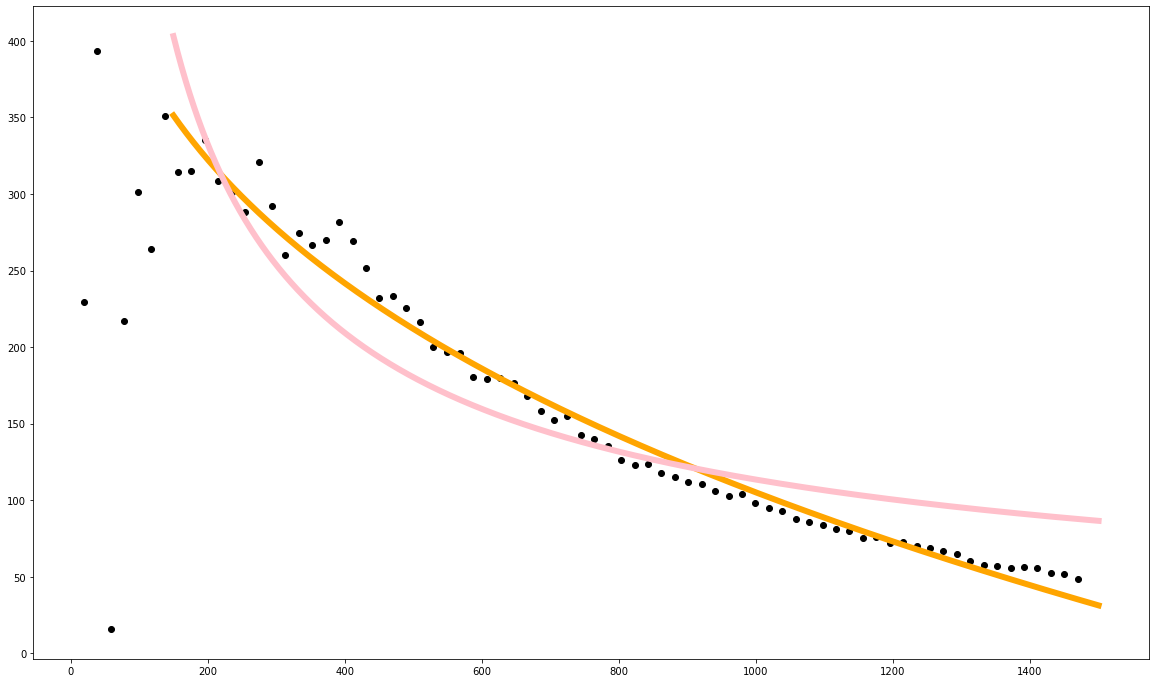

In [172]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[0][1:-25, 0]*px2mm/10, res[0][1:-25, 1]*px2mm*fps, c='k')

result_pow = optimize.leastsq(fit_pow, np.array([1., 1., 1.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))
result_pow2 = optimize.leastsq(fit_pow2, np.array([1., 1.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))

r2_pow = metrics.r2_score(res[0][7:-25, 1]*px2mm*fps, func_pow(result_pow[0], res[0][7:-25, 0]*px2mm/10))
r2_pow2 = metrics.r2_score(res[0][7:-25, 1]*px2mm*fps, func_pow2(result_pow2[0], res[0][7:-25, 0]*px2mm/10))

print(result_pow[0][0], result_pow[0][1], result_pow[0][2], r2_pow)
print(result_pow2[0][0], result_pow2[0][1], r2_pow2)

ax.plot(r, result_pow[0][0] * np.power(r, result_pow[0][1]) + result_pow[0][2], linewidth=6, c='orange')
ax.plot(r, result_pow2[0][0] * np.power(r, result_pow2[0][1]), linewidth=6, c='pink')

plt.show()

-67.83923707786849 0.30547213461331657 664.7802336403385 0.981845118865104
-208.1072662109351 0.22974420787669958 1150.5548386525668 0.9730427683050493
-821.3060603926989 0.11954612109354054 2023.3739497287243 0.9778892439755243


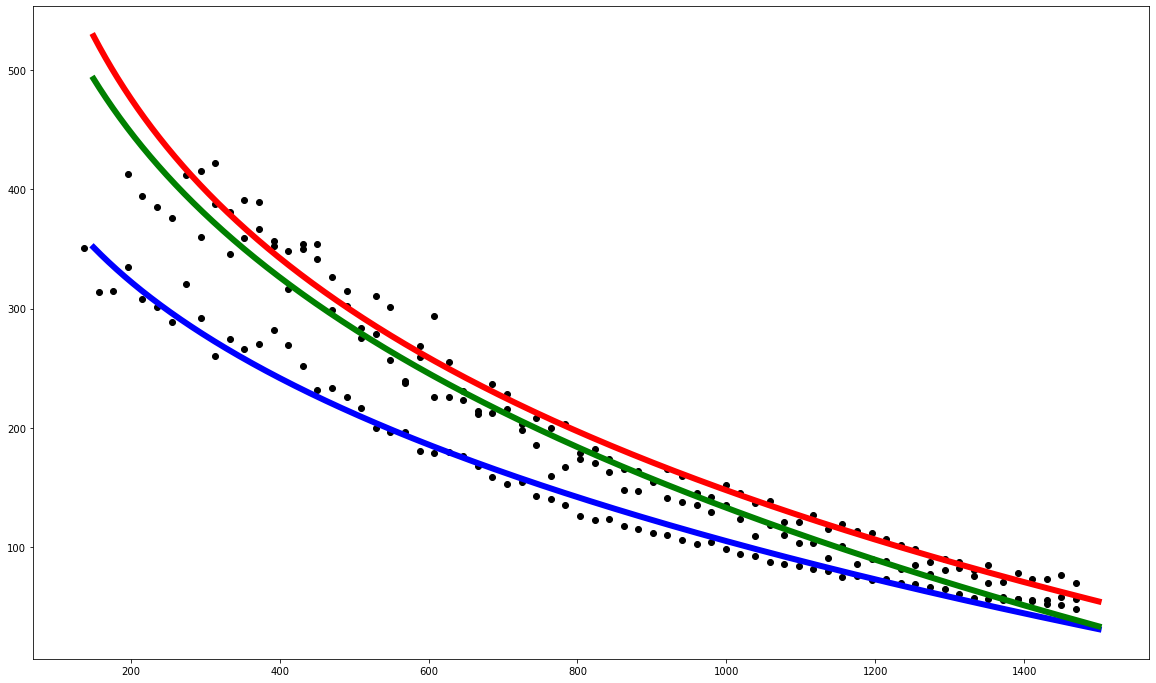

In [173]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[1][10:-25, 0]*px2mm/10, res[1][10:-25, 1]*px2mm*fps, c='k')
ax.scatter(res[2][15:-25, 0]*px2mm/10, res[2][15:-25, 1]*px2mm*fps, c='k')

result_pow = optimize.leastsq(fit_pow, np.array([1., 1., 1.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))
result_pow2 = optimize.leastsq(fit_pow, np.array([1., 1., 1.]), args=(res[1][10:-25, 0]*px2mm/10, res[1][10:-25, 1]*px2mm*fps))
result_pow3 = optimize.leastsq(fit_pow, np.array([1., 1., 1.]), args=(res[2][15:-25, 0]*px2mm/10, res[2][15:-25, 1]*px2mm*fps))

r2_pow = metrics.r2_score(res[0][7:-25, 1]*px2mm*fps, func_pow(result_pow[0], res[0][7:-25, 0]*px2mm/10))
r2_pow2 = metrics.r2_score(res[1][10:-25, 1]*px2mm*fps, func_pow(result_pow2[0], res[1][10:-25, 0]*px2mm/10))
r2_pow3 = metrics.r2_score(res[2][15:-25, 1]*px2mm*fps, func_pow(result_pow3[0], res[2][15:-25, 0]*px2mm/10))

print(result_pow[0][0], result_pow[0][1], result_pow[0][2], r2_pow)
print(result_pow2[0][0], result_pow2[0][1], result_pow2[0][2], r2_pow2)
print(result_pow3[0][0], result_pow3[0][1], result_pow3[0][2], r2_pow3)

ax.plot(r, result_pow[0][0] * np.power(r, result_pow[0][1]) + result_pow[0][2], linewidth=6, c='b')
ax.plot(r, result_pow2[0][0] * np.power(r, result_pow2[0][1]) + result_pow2[0][2], linewidth=6, c='g')
ax.plot(r, result_pow3[0][0] * np.power(r, result_pow3[0][1]) + result_pow3[0][2], linewidth=6, c='r')

plt.show()

In [174]:
r = np.linspace(0, 1500, 1501)

In [175]:
def fit_linear(params, x, y):
    return y - (params[0] * x)

def func_linear(params, x):
    return params[0] * x

2.817794164760883 -0.7537385033047848
438.54720538205623 -0.0014678951107303289 0.9867802703858709


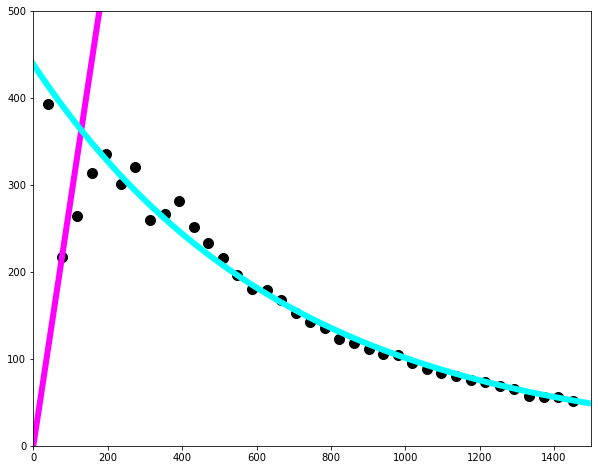

In [176]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlim(0, 1500)
plt.ylim(0, 500)

ax.scatter(res[0][:-25, 0][::2]*px2mm/10, res[0][:-25, 1][::2]*px2mm*fps, c='k', marker='o', s=100)

result_linear = optimize.leastsq(fit_linear, np.array([0.]), args=(res[0][1:7, 0]*px2mm/10, res[0][1:7, 1]*px2mm*fps))
result_exp = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[0][7:-25, 0]*px2mm/10, res[0][7:-25, 1]*px2mm*fps))

r2_linear = metrics.r2_score(res[0][1:7, 1]*px2mm*fps, func_linear(result_linear[0], res[0][1:7, 0]*px2mm/10))
r2_exp = metrics.r2_score(res[0][7:-25, 1]*px2mm*fps, func_exp(result_exp[0], res[0][7:-25, 0]*px2mm/10))

print(result_linear[0][0], r2_linear)
print(result_exp[0][0], result_exp[0][1], r2_exp)

ax.plot(r, result_linear[0][0] * r, linewidth=6, c='magenta')
ax.plot(r, result_exp[0][0] * np.exp(result_exp[0][1] * r), linewidth=6, c='cyan')

plt.show()
fig.savefig('10.png')

1.6353857145443547 0.4782066749613725
619.896349762473 -0.001580380688533468 0.9770331003300629


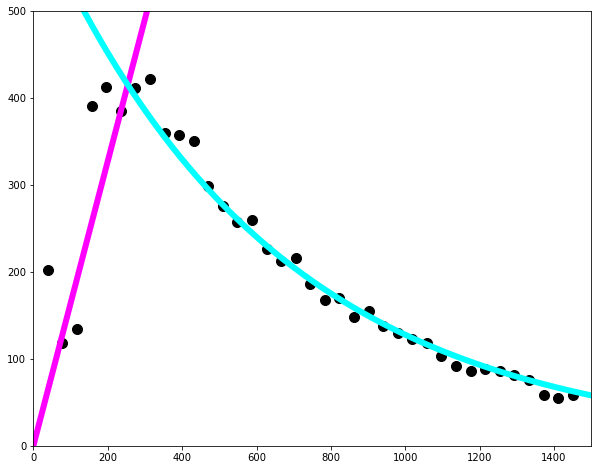

In [177]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlim(0, 1500)
plt.ylim(0, 500)

ax.scatter(res[1][:-25, 0][::2]*px2mm/10, res[1][:-25, 1][::2]*px2mm*fps, c='k', marker='o', s=100)

result_linear = optimize.leastsq(fit_linear, np.array([9.]), args=(res[1][1:10, 0]*px2mm/10, res[1][1:10, 1]*px2mm*fps))
result_exp = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[1][10:-25, 0]*px2mm/10, res[1][10:-25, 1]*px2mm*fps))

r2_linear = metrics.r2_score(res[1][1:10, 1]*px2mm*fps, func_linear(result_linear[0], res[1][1:10, 0]*px2mm/10))
r2_exp = metrics.r2_score(res[1][10:-25, 1]*px2mm*fps, func_exp(result_exp[0], res[1][10:-25, 0]*px2mm/10))

print(result_linear[0][0], r2_linear)
print(result_exp[0][0], result_exp[0][1], r2_exp)

ax.plot(r, result_linear[0][0] * r, linewidth=6, c='magenta')
ax.plot(r, result_exp[0][0] * np.exp(result_exp[0][1] * r), linewidth=6, c='cyan')

plt.show()
fig.savefig('20.png')

0.4727124010875889 0.4635959931368778
0.8520177909092898 -1.5617359572986436
623.6500769254951 -0.0014709771670598233 0.9804792244922871


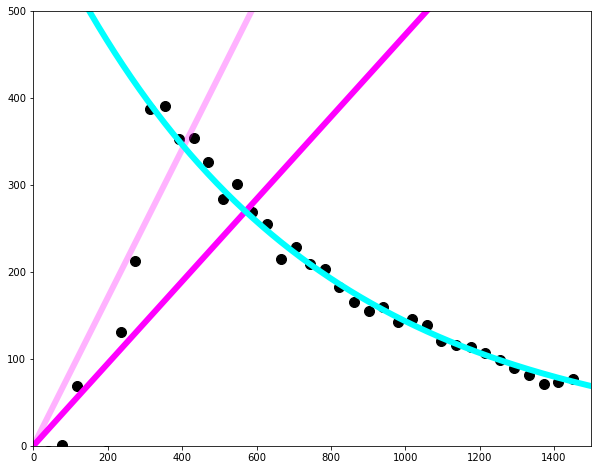

In [178]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlim(0, 1500)
plt.ylim(0, 500)

ax.scatter(res[2][:-25, 0][::2]*px2mm/10, res[2][:-25, 1][::2]*px2mm*fps, c='k', marker='o', s=100)

result_linear = optimize.leastsq(fit_linear, np.array([9.]), args=(res[2][1:15, 0]*px2mm/10, res[2][1:15, 1]*px2mm*fps))
result_linear2 = optimize.leastsq(fit_linear, np.array([9.]), args=(res[2][13:15, 0]*px2mm/10, res[2][13:15, 1]*px2mm*fps))
result_exp = optimize.leastsq(fit_exp, np.array([9., 0.]), args=(res[2][15:-25, 0]*px2mm/10, res[2][15:-25, 1]*px2mm*fps))

r2_linear = metrics.r2_score(res[2][1:15, 1]*px2mm*fps, func_linear(result_linear[0], res[2][1:15, 0]*px2mm/10))
r2_linear2 = metrics.r2_score(res[2][13:15, 1]*px2mm*fps, func_linear(result_linear2[0], res[2][13:15, 0]*px2mm/10))
r2_exp = metrics.r2_score(res[2][15:-25, 1]*px2mm*fps, func_exp(result_exp[0], res[2][15:-25, 0]*px2mm/10))

print(result_linear[0][0], r2_linear)
print(result_linear2[0][0], r2_linear2)
print(result_exp[0][0], result_exp[0][1], r2_exp)

ax.plot(r, result_linear[0][0] * r, linewidth=6, c='magenta')
ax.plot(r, result_linear2[0][0] * r, linewidth=6, c='magenta', alpha=0.3)
ax.plot(r, result_exp[0][0] * np.exp(result_exp[0][1] * r), linewidth=6, c='cyan')

plt.show()
fig.savefig('30.png')

In [245]:
q = [17*1e-5, 33*1e-5, 50*1e-5]
A = [2.817794164760883, 1.6353857145443547, 0.8520177909092898]
alpha = [438.54720538205623*1e-3, 619.896349762473*1e-3, 623.6500769254951*1e-3]
beta = [-0.0014678951107303289, -0.001580380688533468, -0.0014709771670598233]

In [246]:
def fit_for_q(params, x, y):
    return y - (np.power(x, 0.8) + params[0])

def func_for_q(params, x):
    return np.power(x, 0.8) + params[0]

In [247]:
aa = optimize.leastsq(fit_for_q, np.array([0.]), args=(q, A))

qq = np.linspace(1, 100, 100)

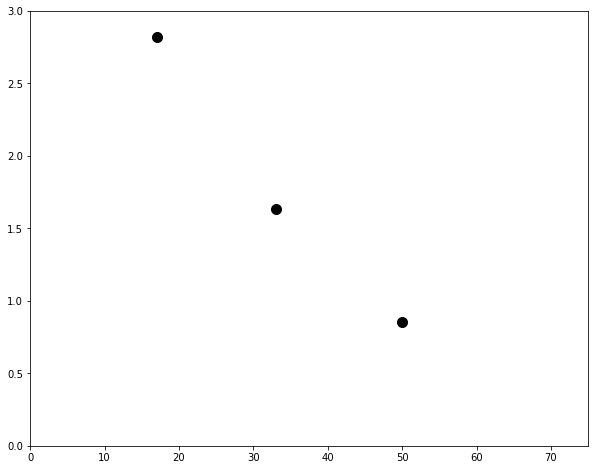

In [241]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlim(0, 75)
plt.ylim(0, 3)

ax.scatter(q, A, c='k', marker='o', s=100)

plt.show()

In [242]:
def fit_for_q(params, x, y):
    return y - (np.power(x, 0.33) * params[0] + params[1])

def func_for_q(params, x):
    return np.power(x, 0.33) * params[0] + params[1]

In [243]:
aa = optimize.leastsq(fit_for_q, np.array([0., 0.]), args=(q, alpha))

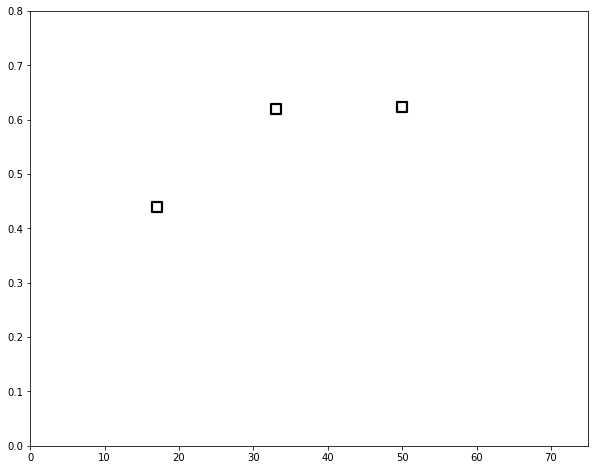

In [244]:
fig, ax = plt.subplots(figsize=(10, 8))
# plt.xlim(0, 75)
plt.ylim(0, 0.8)

ax.scatter(q, alpha, c='w', marker='s', s=100, edgecolors='k', linewidths=2.2)
ax.plot(qq, 180 * np.power(qq, 0.33), c='r', linewidth=2.5)

plt.show()

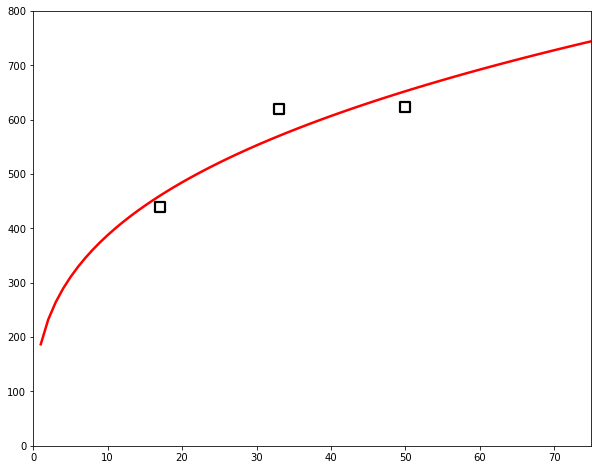

In [223]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlim(0, 75)
plt.ylim(0, 800)

ax.scatter(q, alpha, c='w', marker='s', s=100, edgecolors='k', linewidths=2.2)
ax.plot(qq, aa[0][0] * np.power(qq, 0.33) + aa[0][1], c='r', linewidth=2.5)

plt.show()
fig.savefig('c.png')

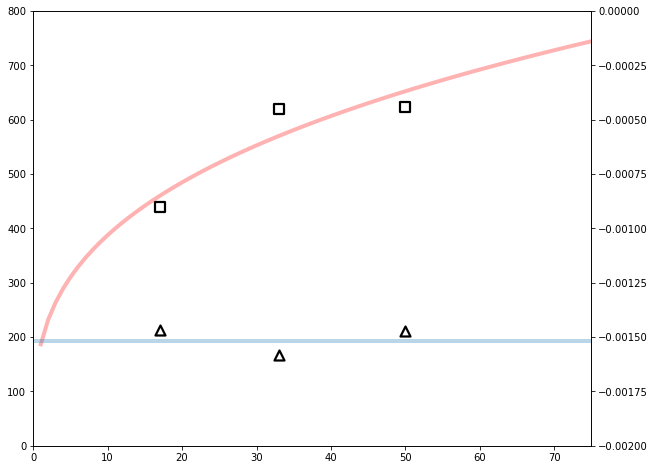

In [235]:
fig, ax = plt.subplots(figsize=(10, 8))
ax2 = ax.twinx()

plt.xlim(0, 75)
ax.set_ylim(0, 800)
ax2.set_ylim(-0.002, 0)

ax.scatter(q, alpha, c='w', marker='s', s=100, edgecolors='k', linewidths=2.2)
ax.plot(qq, aa[0][0] * np.power(qq, 0.33) + aa[0][1], c='r', linewidth=4, alpha=0.3)
ax2.scatter(q, beta, c='w', marker='^', s=100, edgecolors='k', linewidths=2.2)
ax2.hlines(-0.00152, 0, 75, linewidth=4, alpha=0.3)

plt.show()
fig.savefig('c2.png')

In [232]:
x = [1, 1.5, 2, 2.5, 3]
y = [297.2085231640172, 320.99493697147204, 304.10502690882515, 291.55305142597416, 298.50374052375736]
y2 = [-0.010916513517494267, -0.009732001494027526, -0.008235434093105216, -0.007358043437038975, -0.007600281124918739]

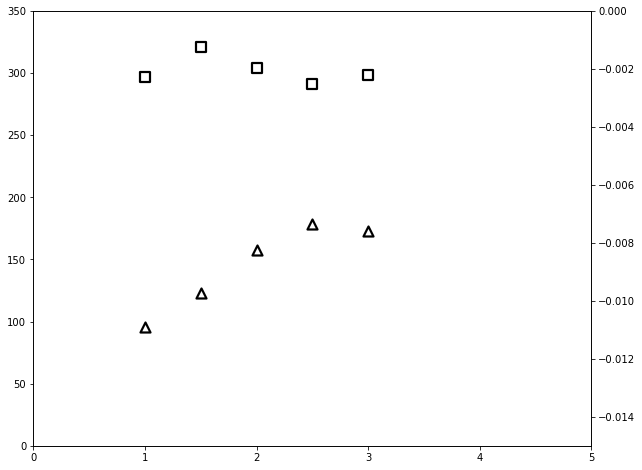

In [236]:
fig, ax = plt.subplots(figsize=(10, 8))
ax2 = ax.twinx()

plt.xlim(0, 5)
ax.set_ylim(0, 350)
ax2.set_ylim(-0.015, 0)

ax.scatter(x, y, c='w', marker='s', s=100, edgecolors='k', linewidths=2.2)
# ax.plot(qq, aa[0][0] * np.power(qq, 0.33) + aa[0][1], c='r', linewidth=2.5)
ax2.scatter(x, y2, c='w', marker='^', s=100, edgecolors='k', linewidths=2.2)
# ax2.hlines(-0.00152, 0, 75, linewidth=2.5)

plt.show()
fig.savefig('c2_0910.png')